<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

<H3 align='center'> Jorge Contreras Cabrera 201573547-6  </H3>
<H3 align='center'> César Quiroz Mansilla 201573578-6   </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* SVM, Decision trees y Redes neuronales
* Tipos de fronteras de clasificación y regresión.
* Métodos de *kernel*.
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Tipos de fronteras en clasificación  
[2.](#segundo) Un problema* Multi-label*  
[3.](#tercero) *Taxi Trip Duration*: Predicción de duración de viaje  
[4.](#cuarto) Entendimiento de imágenes de personas

<a id="primero"></a>
## 1. Tipos de fronteras en clasificación

Como se ha discutido en clases, los problemas de clasificación pueden ser representados de distintas maneras, en donde estas representaciones definen un espacio de entrada del dominio de los datos ($\mathbb{R}_{\mathbb{X}}$). Los ejemplos dentro del espacio de entrada (*manifold*) pueden tener distintas formas, donde estas indicarán si es que estos ejemplos tendrán fronteras lineales o no. Con el propósito de analizar los distintos tipos de fronteras que definen los algoritmos de clasificación, se trabajará con un dataset sintético lo cual es ideal para analizar los diferentes tipos, así hacer un recorrido rápido por las grandes ideas en la búsqueda dela no-linealidad.

Este dataset de jugete está en un espacio de 2 dimensiones y es conformado por dos conjuntos de datos, pudiendo ver que la frontera entre ellos claramente no es lineal. El dataset representa al problema XOR, pero para trabajarlo de una manera distinta se generán gausianas para agregar un poco de ruido en el conjunto de entrenamiento y que no sea un problema trivial. El código que los genera es el siguiente:

In [26]:
import numpy as np
def do_gaussianXOR(n1=250,n2=250):
    rng = np.random.RandomState(0)
    u = 0.5
    std = 0.3 #el ruido se agrega aca
    primer_c = rng.normal(loc=[u,u],scale=std,size=(n1,2))
    segundo_c = rng.normal(loc=[-u,u],scale=std,size=(n2,2))
    tercer_c = rng.normal(loc=[-u,-u],scale=std,size=(n1,2))
    cuarto_c = rng.normal(loc=[u,-u],scale=std,size=(n2,2))
    X_train = np.vstack((primer_c,segundo_c,tercer_c,cuarto_c))
    Y_train = np.hstack((np.zeros(n1),np.ones(n2),np.zeros(n1),np.ones(n2)))   
    X_test = rng.uniform(low=-1.0,high=1.0,size=( (n1+n2),2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    return X_train,Y_train,X_test,Y_test

### El problema XOR
+ Uno de los problemas más conocidos que no podía resolver el Perceptron era una función lógica llamada XOR. Las funciones lógicas tienen normalmente dos entradas y una salida que depende de los valores de las entradas. Las entradas y las salidas pueden tomar dos valores: Verdadero (0) y Falso (1). Así para cada función lógica existe una tabla que indica cuál será la salida dada la combinación de los valores de la entrada.

<img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/ttabxor.gif" title="Title text" width="40%" height="20%" />

#### a) Construya el conjunto de datos (*dataset*) y describa el proceso de creación de éstos. Determine cuántos registros contiene cada conjunto y visualı́celos.

Cantidad de ejemplos enetrenamiento 1000
Cantidad de ejemplos validación 500


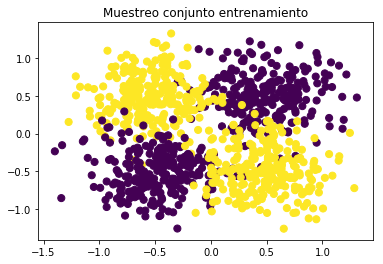

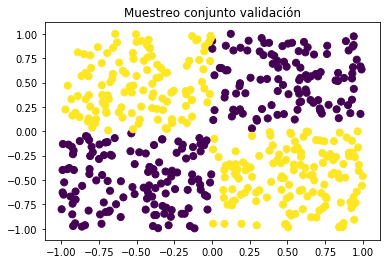

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

X_train,Y_train,X_test,Y_test = do_gaussianXOR()
print("Cantidad de ejemplos enetrenamiento",len(X_train))
print("Cantidad de ejemplos validación",len(X_test))
plt.scatter(X_train[:,0],X_train[:,1],s=50,c=Y_train)
plt.title("Muestreo conjunto entrenamiento")
plt.show()
plt.scatter(X_test[:,0],X_test[:,1],s=50,c=Y_test)
plt.title("Muestreo conjunto validación")
plt.show()

+ El conjunto de entrenamiento tiene 1000 ejemplos, mientras que el conjunto de prueba solo 500, es decir se tiene el triple de ejemplos en es conjunto de estrenamiento.
+ Para la creaciòn de ambos conjuntos de utilizo la función do_gaussianXOR.
+ El conjunto de entrenmiento sigue una distribución normal mientras que el se validación una uniforme.
+ Tiene una media de 0.5 y una desviación estandar de 0,3 (que genera el ruido sobre el conjunto de entrenamiento).

En las figuras:
+ Los puntos morados corresponden a 0 y los puntos amarrillos corresponden a 1.
+ El primer cuadrante es 0 debido a que ambos x son positivos
+ El segundo cuadrante es un 1 debido  que un x es positivo y el otro es negativo.

#### b) Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Comente cualitativamente lo que observa.

In [28]:
# Para visualizar las fronteras
import matplotlib.pyplot as plt

def visualize_border(model,x,y,title=""):
    fig, axis = plt.subplots(1, 1,figsize=(7, 6))

    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #or predict_proba
    Z = Z.reshape(xx.shape)
    Zplot = Z > 0.5
    
    axis.scatter(x[:,0],x[:,1],s=50,c=y,zorder=10,cmap=plt.cm.winter)
    axis.contour(xx, yy, Z,levels=[-1, 0, 1])
    axis.pcolormesh(xx, yy, Zplot ,cmap=plt.cm.YlGn)
    plt.title(title)
    plt.show()

Test Accuracy:  0.466


/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


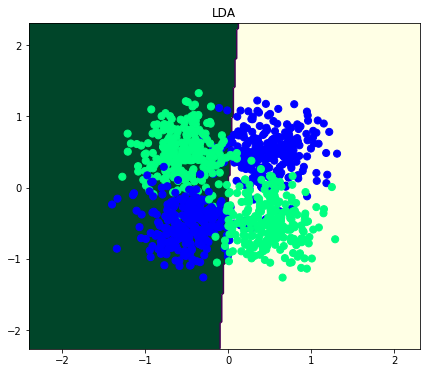

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))
visualize_border(model,X_train,Y_train,"LDA")

+ El modelo LDA tiene un accuracy del 46,6%, esto se debe a que el modelo LDA es lineal, esto se obserba en la figura anterior.

#### c) Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué  distribución de probabilidad asumen cada uno?

/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


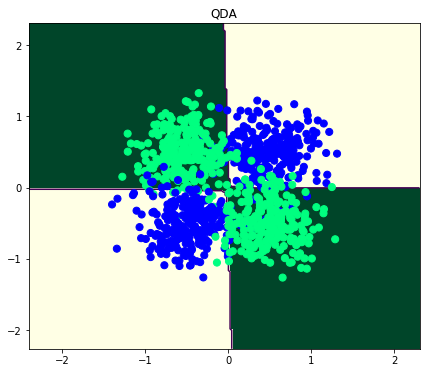

In [30]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA()
model.fit(X_train,Y_train)
visualize_border(model,X_train,Y_train,"QDA")

+ QDA funciona mejor que LDA, ya que LDA solo permite fronteras lineales y los datos no pueden ser separados por una sola linea recta y QDA si lo permite. 
+ Además QDA puede ser un LDA pero no viceversa.
+ QDA en estricto rigor son dos cuadraticas.
+ Los puntos siguen una distribución normal

#### d) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) Lineal no puede resolver el problema, para esto construyala a través de *sklearn*. Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$. Analice cualitativamente lo observado, para validar su análisis cualitativo calcule el *accuracy* sobre el conjunto de pruebas.

Para lo que sigue de la actividad se trabajará con una widget interactiva para sintonizar los parámetros de regularización o estructurales de los distintos algoritmos. Por ello cada vez que se modifique el parámetro en la ventana se entrenará el modelo y se visualizará la frontera en la misma imagen.

In [31]:
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X_train,Y_train,"Modelo") #here choose train/test or both!

In [32]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='linear')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -6 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=-1, description='param', max=4, min=-6), Output()), _dom_classes=('widge…

+ La SVM lineal tiene mejor accuaracy con el parametro c=0.1, sin embrago no supera el 50% debido a que solo soporta diviciones lineales.
+ el parametro C define cuantos puntos pueden ignirarse pero en este caso sin importar cuantos se ignoren la probabilidad sera siempre del 50% aproximadamente.

#### e) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) no Lineal puede resolver el problema, para ésto construya una SVM no Lineal a través de un **kernel** . Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$ y con diferentes kernels. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [33]:
#edit the train_model function
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='rbf')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -6 #define your range
p_max = 4 #define your range

interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=-1, description='param', max=4, min=-6), Output()), _dom_classes=('widge…

+ La SVM no linear rdf presenta un accuracy de 98% con un parametro c= 1

In [34]:
def visualize_border_interactive2(param,d):
    model = train_model(param,d)
    visualize_border(model,X_train,Y_train,"Modelo")
    
def train_model(param,d):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    print("Param D=", d)
    model.set_params(C=C,kernel='poly',degree=d)
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -6 #define your range
p_max = 6 #define your range
d_min=2
d_max=10

interactive(visualize_border_interactive2,param=(p_min,p_max),d=(d_min,d_max))

interactive(children=(IntSlider(value=0, description='param', max=6, min=-6), IntSlider(value=6, description='…

+ La SVM con poly solo llego al acurracy del 98,6% con un parametro d=2 y un parametro c=0,1.
+ D corresponde al grado, y por alguna razon con grados impares el modelo SVM poly no es util pero con valores pares funciona muy bien.

#### f) Demuestre experimentalmente que un Árbol de Decisión de múltiples niveles puede resolver el problema ¿Qué pasa con un nivel? Para ésto contruya el Árbol de Decisión a través de *sklearn*, puede utilizar el criterio y la función de partición que prefiera. Mediante la *widget* interactiva explore diferentes valores del parámetro de máxima profundidad del árbol. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [37]:
from sklearn.tree import DecisionTreeClassifier as Tree
def train_model(param):
    model= Tree()
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    print("Train Accuracy: ",model.score(X_train,Y_train))
    return model

p_min = 1 #define your range
p_max = 40 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=20, description='param', max=40, min=1), Output()), _dom_classes=('widge…

+ Con un nivel solo se consigue un accuracy del 47%, resultado similar al que se consigue con LDA

+ El mejor resultado es con 3 niveles consiguiendo un accuracy del test 97%

+ Despues de cierta cantitidades (11) de nivel la accuracy para el test se mantiene en 92% y el acurracy del train es del 100% esto implica que en cada hoja del arbol hay valores unicos. Por lo tanto la información es util bajo el nivel 11.


#### g) Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema. Para esto construya un perceptrón multi-capa, con una capa escondida, variando el número de neuronas $N_h$ a través de la *widget* interactiva. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    print("Train Accuracy: ",model.evaluate(X_train, Y_train,batch_size=128,verbose=0)[1])
    return model
p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=5, description='param', max=10), Output()), _dom_classes=('widget-intera…

+ Se consiguen un mejor accuracy del test con 128 neuronas llegando al 98%

#### h) Construya un algoritmo $k$-NN para la clasificación del problema. Mediante la *widget* interactiva explore diferentes valores del parámetro $k$. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [44]:
from sklearn.neighbors import KNeighborsClassifier

def train_model(param):
    k=param
    print("Parametro K = ",k)
    model = KNeighborsClassifier()  
    model.set_params(n_neighbors=param)
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 0 #define your range
p_max = 100 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=50, description='param'), Output()), _dom_classes=('widget-interact',))

+ El mejor resultado se registro con 45 vecinos llegando al 98,2% de accuraacy.
+ Además los valores oscilan entre 88 y 97 porciento para distintos valores de k, sin embrago al crecer mucho el valor de k los resultados empeoran.

#### i) Vuelva a generar datos, pero ahora de manera desbalanceada por clase, con más ejemplos en una clase que en otra, pero manteniendo el conjunto de pruebas para verificación. Visualicelo apropiadamente.

Cantidad de ejemplos enetrenamiento 510
Cantidad de ejemplos validación 255


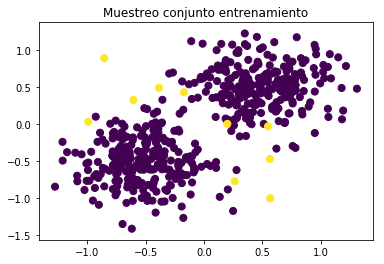

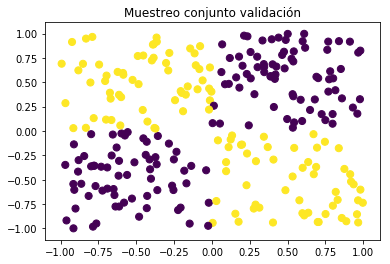

In [45]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR(n1=250,n2=5)
print("Cantidad de ejemplos enetrenamiento",len(X_train))
print("Cantidad de ejemplos validación",len(X_test))
plt.scatter(X_train[:,0],X_train[:,1],s=50,c=Y_train)
plt.title("Muestreo conjunto entrenamiento")
plt.show()
plt.scatter(X_test[:,0],X_test[:,1],s=50,c=Y_test)
plt.title("Muestreo conjunto validación")
plt.show()

#### j) Escoga las Máquinas de Soporte Vectorial con kernel RBF ($C=1$) o un Árbol de Decisión ($depth=5$) para entrenar sobre estos datos desbalanceados, mida el *Accuracy* sobre el conjunto de pruebas.

C 1
Test Accuracy:  0.5568627450980392
Train Accuracy:  0.9803921568627451


/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


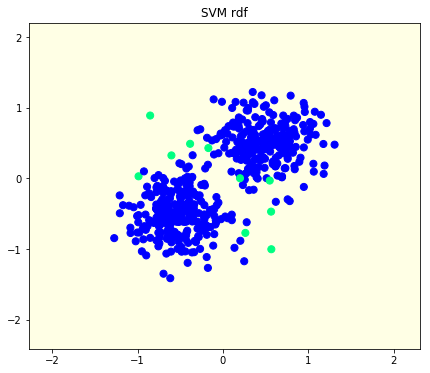

Test Accuracy:  0.5725490196078431
Train Accuracy:  0.9882352941176471


/Users/marcelacamilaosoriofarias/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


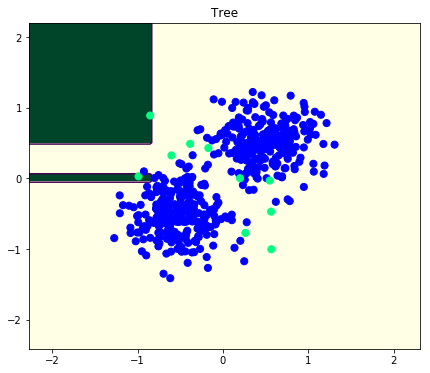

In [51]:
def visualize_border_interactive(param,title):
    model = train_model(param)
    visualize_border(model,X_train,Y_train,title)

#SVM
def train_model(param):
    print("C",param)
    model= SVM()
    model.set_params(C=1,kernel='rbf')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    print("Train Accuracy: ",model.score(X_train,Y_train))
    return model
visualize_border_interactive(param=1,title="SVM rdf")

#Tree
def train_model(param):
    model= Tree()
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    print("Train Accuracy: ",model.score(X_train,Y_train))
    return model
visualize_border_interactive(param=5,title="Tree")


+ Tanto el árbol como la SVM no fuencionan bien y solo consiguen una accuracy del 55% para el el test.

#### k) Ahora verifique que se puede mejorar la métrica a través de poner un peso en la función objetivo para las distintas clases, *seteelo* a mano o utilize la función *balanced* para que reduzca el impacto de lo datos de la clase mayoritaria en la función objetivo o que aumente el impacto de los datos de la clase minoritaria.

In [54]:
classes_weights = {0: 0.11, 1: 5}
#cvm
model= SVM()
model.set_params(C=1,kernel='rbf',class_weight=classes_weights or 'balanced') #for svm
model.fit(X_train,Y_train)
print("Test Accuracy SVM: ",model.score(X_test,Y_test))
print("Train Accuracy SVM: ",model.score(X_train,Y_train))
#tree
model= Tree()
model.set_params(max_depth=5,criterion='gini',splitter='best',class_weight=classes_weights or 'balanced') #for tree
model.fit(X_train,Y_train)
print("Test Accuracy Tree: ",model.score(X_test,Y_test))
print("Train Accuracy Tree: ",model.score(X_train,Y_train))

Test Accuracy SVM:  0.9607843137254902
Train Accuracy SVM:  0.9098039215686274
Test Accuracy Tree:  0.7450980392156863
Train Accuracy Tree:  0.8921568627450981


+ Al modificar los pesos que se le da a la función objetivo se obtiene que lo mejor es dejar a 0,1 en 0,11 y a 1 en 5 consiguiendo un accuracy del 96% para el SVM.
+ Se probaron otros valores, obteniendo  Accuracy más baja para el SVM.
+ El árbol de decisión alcanzo un maximo del 80%. 

<a id="segundo"></a>
## 2. Un problema* Multi-label*

<img src="https://files.virgool.io/upload/users/12226/posts/oxo6jvmweqmr/1ios2rcvohwc.png" width="35%" style="float: right;" />

Un tipo de problema un poco diferente a la clásica clasificación que hemos visto es el de etiquetación múltiple o *multi-label* [[5]](#refs), en donde se debe asignar una *o un grupo* de etiquetas a un dato, es decir, puede ser tratado como un problema de clasificación donde las clases pasan a ser **NO** mutuamente excluyente, es decir puede ser asignada más de una a un dato. Este problema se ve muchas veces en imágenes que contienen más de algun objeto, por lo que las clases pasan a ser no excluyente, o en sí se transforma en un problema de *multi-label*. También aparece en texto cuando se debe asignar un tópico a un documento, ya que podría hablar de diferentes cosas, como religión, política, finanzas o educación, por lo que podría contener varios.


En esta actividad se trabajará con una versión liviana del dataset __[**NUS-WIDE**](https://lms.comp.nus.edu.sg/research/NUS-WIDE.htm)__ , el cual consta de imágenes extraídas de la web (Flickr.com) en donde los diferentes *tags* o conceptos asociados a la imagen pasan a ser las etiquetas/*labels*. De la página donde se alberga NUS-WIDE será necesario descargar:
* Concept List: http://dl.nextcenter.org/public/nuswide/ConceptsList.zip
* NUS-WIDE-Lite: http://dl.nextcenter.org/public/nuswide/NUS-WIDE-Lite.rar
* NUS-WIDE-Urls: http://dl.nextcenter.org/public/nuswide/NUS-WIDE-urls.rar

> a) Cargue los datos del *output* del modelo (*labels*), descríbalos ¿Cuántos ejemplos hay por cada clase?

In [1]:
import pandas as pd
import numpy as np
labels = pd.read_csv("Pregunta2/NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None,engine='python').values
df = pd.read_csv("Pregunta2/NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None,engine='python')
category = pd.read_csv("Pregunta2/Concepts81.txt",delimiter="\s",header=None,engine='python')

In [74]:
d = {}
lista = []
for imagen in labels:
    suma = sum(imagen)
    if suma in d:
        d[suma]+=1
    else:
        d[suma]=1      
for a,b in d.items():
    lista.append((a,b))   
lista.sort()

print('Cantidad de categorias presentes en cada imagen, de la forma')
print('Cantidad de categorias : imagenes con esa cantidad de categorias\n')
for x,y in lista:
    print (x,': ',y)
    
categorias=[]
for x in range(81):
    categorias.append((sum(df[x]),x))
categorias.sort(reverse = True)

print('\nlas categorias mas populares son:\n')
for x in range(5):
    print (category.iloc[categorias[x][1]].values[0],': ',categorias[x][0])

Cantidad de categorias presentes en cada imagen, de la forma
cantidad de categorias : imagenes con esa cantidad de categorias

0 :  1474
1 :  1971
2 :  1292
3 :  742
4 :  10344
5 :  6143
6 :  3385
7 :  1632
8 :  617
9 :  161
10 :  40
11 :  3
12 :  2
13 :  1

las categorias mas populares son:

sky :  19052
clouds :  15538
water :  11019
lake :  5758
grass :  4933


> b) Visualice el tema de que un dato  (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema *multi-label* y cómo aplica en este caso.

Etiquetas de la imagen : ['boats' 'clouds' 'reflection' 'sky']


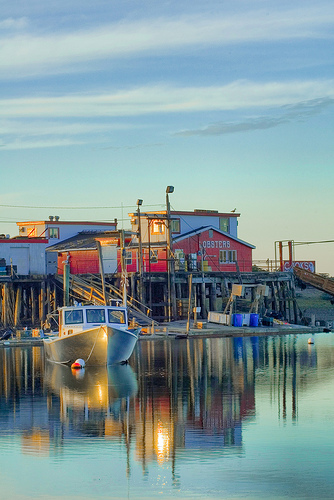

In [31]:
import re
from urllib.request import urlopen
label_names = np.loadtxt("Pregunta2/Concepts81.txt",dtype='object')
arch = open("Pregunta2/NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("Pregunta2/NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()
"""Visualizacion"""
from PIL import Image
s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(labels[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urlopen(data_urls[s]))
im

El problema presentado en este caso es que una imagen en particular, un dato puede estar asociado a múltiples categorías, entonces, a diferencia de problemas anteriores, no está presente la relación 1 a 1, sino que 1 a muchos. Lo anterior tiene múltiples significancias, como por ejemplo que no es posible utilizar cualquier tipo de modelo, ya que se tienen que estandarizar a multilabel o que en las mismas medidas de acuraccy se debe tener mucho cuidado, dado que por ejemplo, el acurracy normal compararaía los vectores, pero si una imagen tiene 10 categoría e identifica 9 correctamente, los vectores (explicados a continuación) serán distintos, pero aún así la aproximación del learner es buena. Todos esos factores se deben tener en cuenta a la hora de modelar y la posterior evaluación.

> c) Comente sobre la **representación** que posee la salida de los modelos (*labels*) ¿En qué dominio habita? ¿Tiene restricciones?

La representación de las imagenes en el modelo se compone por vectores de largo 81, que corresponde a la cantidad de etiquetas presentes. Entonces, cada índice del vector puede tomar los valores 0 ó 1, en donde 0 indica que la etiqueta no se encuentra presente en la imagen y 1 que sí se encuentra presente. Así, la salida está representaba por vectores binarios y su dominio es R^81.

> d) Decida sobre una **representación**, en este caso descriptores, para la entrada a los modelos (*input*), puede utilizar la mezcla entre distintos descriptores, comente sobre la elección y qué representa.

In [4]:
file = "Normalized_CH_Lite_Train.dat"
#or "Normalized_CM55_Lite_Train.dat"
descriptors = pd.read_csv("Pregunta2/NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s",header=None,engine='python').values
descriptors.shape

(27807, 64)

In [ ]:
Se decide utilizar 

> e) Deje un conjunto separado para evaluar los modelos y comportar como conjunto de pruebas, además de realizar la clásica estandarización de las entradas de los modelos.

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(descriptors,labels,test_size=0.33)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

Se crean los respectivos conjuntos de entrenamiento y de testing, para luego hacerles un StandarScaler

> f) Se presenta una métrica para validar en el código a continuación, la cual mide la cantidad de aciertos a las *labels* que tenga un dato de manera normalizada. Defina **otra** métrica a utilizar con el propósito de validar lo mismo (el desempeño de un modelo).

In [6]:
def evaluation_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.sum(y==yp, dtype='float')/len(y)  #cantidad de valores iguales
    return suma/float(len(y_true))   

def alternative_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.linalg.norm(y-yp) 
    return suma/float(len(y_true)) 

Se crea una métrica alternativa, que corresponde a la distancia euclidiana, la razón por la cual se decide trabajar con esta se mencionará en los próximos items, especificamente cuando se trabaja con redes neuronales.

> g) Experimente en resolver el problema con un Árbol de Decisión (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender de manera sencilla a *multi-label* [[4]](#refs). Mida las métricas de desempeño definidas anteriormente sobre ambos conjuntos (entrenamiento y pruebas), comente.

In [7]:
from sklearn.tree import DecisionTreeClassifier as Tree
model = Tree() 
model.set_params(max_depth=None,criterion="gini",splitter="best")
model.fit(X_train,y_train)

model2 = Tree() 
model2.set_params(max_depth=None,criterion="entropy",splitter="best")
model2.fit(X_train,y_train)

model3 = Tree() 
model3.set_params(max_depth=None,criterion="entropy",splitter="random")
model3.fit(X_train,y_train)

model4 = Tree() 
model4.set_params(max_depth=None,criterion="gini",splitter="random")
model4.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

Se crean las posibles combinaciones entre los parámetros disponibles

In [8]:
#Para realizar las predicciones y evaluar utilice:
y_pred = model.predict(X_test)
y_predb = model.predict(X_train)
print(evaluation_metric(y_test,y_pred))
print(evaluation_metric(y_train,y_predb))

y_pred2 = model2.predict(X_test)
y_pred2b = model2.predict(X_train)
print(evaluation_metric(y_test,y_pred2))
print(evaluation_metric(y_train,y_pred2b))

y_pred3 = model3.predict(X_test)
y_pred3b = model3.predict(X_train)
print(evaluation_metric(y_test,y_pred3))
print(evaluation_metric(y_train,y_pred3b))

y_pred4 = model4.predict(X_test)
y_pred4b = model4.predict(X_train)
print(evaluation_metric(y_test,y_pred4))
print(evaluation_metric(y_train,y_pred4b))

0.9350308137493916
0.9999648781005016
0.9344590676907368
0.9999648781005016
0.9331285809801328
0.9999648781005016
0.93409045964351
0.9999648781005016


Los distintos modelos, independiente del parámetro ocupado, presentan valores demasiado similares para la primera métrica, lo cual nos puede indicar, en primera instancia que estos no influyen en los resultados del modelo

In [9]:
#Para realizar las predicciones y evaluar utilice:

print(alternative_metric(y_test,y_pred))
print(alternative_metric(y_train,y_predb))

print(alternative_metric(y_test,y_pred2))
print(alternative_metric(y_train,y_pred2b))

print(alternative_metric(y_test,y_pred3))
print(alternative_metric(y_train,y_pred3b))

print(alternative_metric(y_test,y_pred4))
print(alternative_metric(y_train,y_pred4b))

2.2239813151336856
0.001694249752967999
2.235395206892741
0.001694249752967999
2.263551960778116
0.001694249752967999
2.2408825499028397
0.001694249752967999


Para el caso de la métrica alternativa (distancia euclidiana) los valores también son muy similares entre sí, en donde la ocmbinación criterion="gini", splitter="best" es la que entrega mejores resultados para el conjunto de testing, ya que como es distancia euclidiana, los valores más pequeños son los más cercanos y por ende la representación más correcta.

> h) Experimente en resolver el problema con una Máquina de Soporte Vectorial no lineal (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender a *multi-label* a través de la técnica **OneVsRest**. Mida las métricas de desempeño al igual que para el Árbol de Decisión, comente y compare sobre las métricas y los tiempos de ejecución.


In [ ]:
from sklearn.svm import SVC as SVM #SVC is for classification
from sklearn.multiclass import OneVsRestClassifier
model= SVM()
model.set_params(C=5.0,kernel='rbf')
meta_model = OneVsRestClassifier(model)
meta_model.fit(X_train,y_train)

El modelo nunca termina de correr

> i) Experimente en resolver el problema con una Red Neuronal *Feed Forward* (decida el número de capas y el número de neuronas, si desea puede utilizar las por defecto). Éste modelo se extiende a *multi-label* a través de la interfaz de *keras* seleccionando una *loss* adecuada, en este caso **binary cross entropy** ¿Por qué?

In [82]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
neural = Sequential()
neural.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
neural.add(Dense(128, activation="relu"))
neural.add(Dense(y_train.shape[1], activation="sigmoid"))
neural.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy")
neural.fit(X_train, y_train, epochs=40, batch_size=128, verbose=1)

Epoch 1/40
18630/18630 [==============================] - 1s 30us/step - loss: 0.5034
Epoch 2/40
18630/18630 [==============================] - 0s 20us/step - loss: 0.1917
Epoch 3/40
18630/18630 [==============================] - 0s 24us/step - loss: 0.1564
Epoch 4/40
18630/18630 [==============================] - 1s 30us/step - loss: 0.1494
Epoch 5/40
18630/18630 [==============================] - 1s 27us/step - loss: 0.1462
Epoch 6/40
18630/18630 [==============================] - 0s 23us/step - loss: 0.1441
Epoch 7/40
18630/18630 [==============================] - 1s 28us/step - loss: 0.1425
Epoch 8/40
18630/18630 [==============================] - 0s 24us/step - loss: 0.1412
Epoch 9/40
18630/18630 [==============================] - 0s 20us/step - loss: 0.1402
Epoch 10/40
18630/18630 [==============================] - 0s 20us/step - loss: 0.1393
Epoch 11/40
18630/18630 [==============================] - 0s 20us/step - loss: 0.1384
Epoch 12/40
18630/18630 [===========================

Se trabaja con binary cross entropy dado que los datos vienen dados de acuerdo a vectores binarios, 0 ó 1, entonces, con binary cross entropy se pueden clasificar dos clases, que la categoría esté presente y que no lo esté. Es innecesario utilizar categorical cross entropy, ya que esta sirve para una ilimitada cantidad de clases, lo cual en este caso no sucede. En teoría, binary cross entropy es un caso especial de categorical cross entropy, más óptimo para el modelo actual.

> j)  Realice predicciones **probabilísticas** de su modelo ¿Las probabilidades están normalizadas? ¿Por qué? Además defina una forma para pasar de la representación de las probabilidades a la representación de *labels* categoricos definidos como en c).  
*Hint: Recuerde que el no pertenecer a ninguna *label*/etiqueta es una posibilidad!!*

In [83]:
neural_pred = neural.predict(X_test)
neural_predb = neural.predict(X_train)
print(evaluation_metric(y_test,neural_pred))
print(evaluation_metric(y_train,neural_predb))
print(alternative_metric(y_test,neural_pred))
print(alternative_metric(y_train,neural_predb))

0.0
0.0
1.6219405532150044
1.6186085617444514


El modelo de redes neuronales, para la primera métrica, entrega valores de cero para am,bos conjuntos, esto se debe a que esta métrica verifica si el valor predecido es igual al real, es decir si los unos son unos y os ceros son ceros, pero el modelo de redes neuronales entrega una probabilidad de que eso suceda, por lo cual, nunca o casi nunca tomará valores de 0 ó 1, sino que probabilidades de que eso suceda, por lo cual es lógico que la métrica entregue cero, es por esto que se aplicó la distancia euclidiana, para ver que tan lejanos (o cercanos) están los valores predecidos por la red neuronal.

In [84]:
def transform(datos):
    i=0
    new_neural_pred = np.zeros((datos.shape[0], 81))
    for imagen in datos:
        j = 0
        while j < 81:
            if(datos[i][j]>0.5):
                new_neural_pred[i][j]=1
            else:
                new_neural_pred[i][j]=0
            j+=1
        i+=1
    return (new_neural_pred)

Si la probabilidad es mayor al 50% se decide identificar la predicción como 1, sino, la predicción se identifica como 0

> k) Ahora que recuperó la representación de las *labels* mida las métricas de desempeño sobre la Red Neuronal. Compare y comente.

In [85]:
new_neural_pred = transform(neural_pred)
new_neural_predb = transform(neural_predb)

In [86]:
print(evaluation_metric(y_test,new_neural_pred))
print(evaluation_metric(y_train,new_neural_predb))

print(alternative_metric(y_test,new_neural_pred))
print(alternative_metric(y_train,new_neural_predb))

0.9578226295744837
0.9579557729137511
1.7782014152911485
1.7756299715896147


La red neuronal entrega valores muy similares para el train y para el testing, con un 95% para la primera métrica y valores de 1.7 para la distancia euclidiana, entonces, entrega resultados peores que el árbol de decisión para la primera métrica, pero valores superiores para la segunda métrica, la definida según distancia euclidiana.

<a id="tercero"></a>

## 3. *Taxi Trip Duration*: Predicción de duración de viaje

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Newyorkcity_taxi_motion_banner.jpg" />


En esta actividad trabajaremos con un dataset de una competencia en la plataforma Kaggle, el cual se llama **New York City Taxi Trip Duration** y que puede ser accedido a través del siguiente __[link](https://www.kaggle.com/c/nyc-taxi-trip-duration/)__. Como se puede ver es una competencia para predecir la duración del viaje de un taxi en Nueva York, por lo que es un problema de regresión que resulta altamente no lineal  y no determinista debido a las invariantes que tiene, por ejemplo un viaje de un punto a otro puede durar distinto tiempo dependiendo de múltiples factores, como el horario, la congestión de ese día u otros.

La métrica de evaluación de la competencia y la que utlizaremos será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

O en código Python:
```python
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))
```


Descarge los datos de la competencia, únicamente trabajaremos con el archivo *train.zip* o *train.csv*, ya que no conocemos los valores reales del conjunto *test*, tendrémos que simularlo.


> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [1]:
import pandas as pd
df = pd.read_csv("Pregunta3/train.csv")
output = df['trip_duration'].values
df.head(20)



,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


Tipos de datos de cada columna
 id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object 


Cantidad de valores distinos

id:  1458644
id vendedor:  2
pickup_datetime:  1380222
dropoff_datetime:  1380377
passenger_count:  10
pickup_longitude:  23047
pickup_latitude:  45245
dropoff_longitude:  33821
dropoff_latitude:  62519
store_and_fwd_flag:  2
trip_duration:  7417
AxesSubplot(0.125,0.125;0.775x0.755)


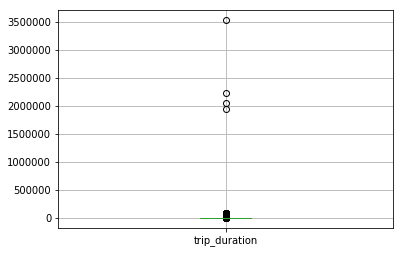

In [3]:
print('Tipos de datos de cada columna\n',df.dtypes,'\n')
print('\nCantidad de valores distinos\n')
print('id: ',df.id.nunique())
print('id vendedor: ',df.vendor_id.nunique())
print('pickup_datetime: ',df.pickup_datetime.nunique())
print('dropoff_datetime: ',df.dropoff_datetime.nunique())
print('passenger_count: ',df.passenger_count.nunique())
print('pickup_longitude: ',df.pickup_longitude.nunique())
print('pickup_latitude: ',df.pickup_latitude.nunique())
print('dropoff_longitude: ',df.dropoff_longitude.nunique())
print('dropoff_latitude: ',df.dropoff_latitude.nunique())
print('store_and_fwd_flag: ',df.store_and_fwd_flag.nunique())
print('trip_duration: ',df.trip_duration.nunique())

print (df.boxplot(column='trip_duration',return_type='axes'))

b) Como puede observar en los análisis preliminares exiten algunos outliers en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

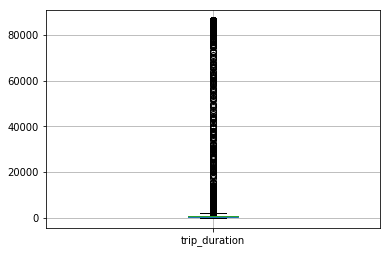

In [4]:
#eliminar outliers
df = df[(df['trip_duration']<=100000)]

df.loc[df['trip_duration'].idxmax()]

df.boxplot(column='trip_duration',return_type='axes')

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hacer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.

In [5]:
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.

In [6]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

> e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.

In [7]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

n_h=2**(2)
print("Neuron hidden = ",n_h)
model = Sequential()
model.add(Dense(n_h, input_dim=X_train_scaled.shape[1], activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train_scaled, y_train, epochs=25, batch_size=128, verbose=0)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test))

C:\Users\Jorge\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Neuron hidden =  4
ERROR RMSLE de training:  [5.82877905]
ERROR RMSLE de test:  [5.82742634]


> f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?

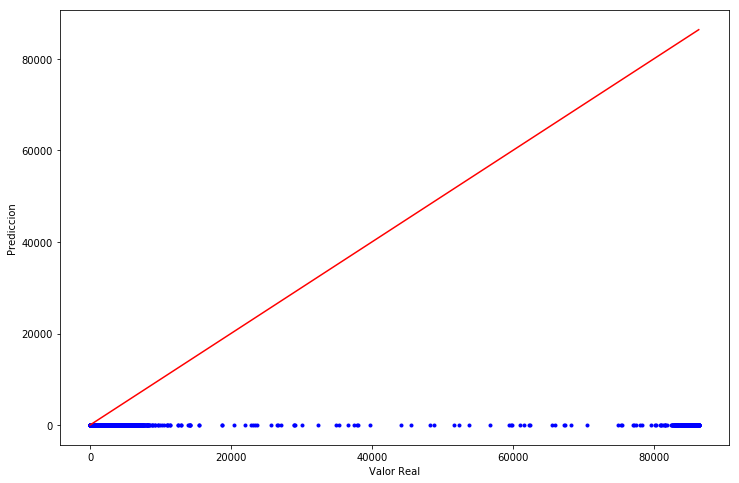

In [9]:
import matplotlib.pyplot as plt
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
graficar_predicciones(y_test,model.predict(X_test_scaled))

> g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 

In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_test_scaled, y_test, cv=5)
scores

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x000002500890DC88> does not.

> h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering* [[6]](#refs). Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).

> i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.

In [ ]:
"""define your transformation!!"""
def transformar(valor):
    return valor #identidad
def destransformar(valor):
    return valor #identidad
model.fit(X_train_scaled,transformar(y_train))
print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train_scaled)),y_train)
print "ERROR RMSLE de test: ", rmsle(destransformar(model.predict(X_test_scaled)),y_test)

> j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.

In [ ]:
"""Separar viajes largos de viajes cortos"""
u = np.mean(X_train["distancia_viaje_km"])
mask = X_train["distancia_viaje_km"] <= u
X_train_1 = X_train[mask] #viaje cortos
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask] #viaje largos
y_train_2 = y_train[~mask]

## 4. Entendimiento de imágenes de personas

El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante difícil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.


<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />


En esta actividad trabajaremos con unos datos (imágenes) con la tarea de predecir la **edad** (*target value*) de la persona en la imagen. Los datos corresponden a 3640 imágenes de Flickr de rostros de personas, pero para simplificar el manejo y cómputo, se trabajará con representaciones de características extraídas (descriptores). Para ésto necesitará descargar los datos del siguiente __[link](http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html)__ en el extracto de *ageGenderClassification*

#### a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?

In [102]:
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

FileNotFoundError: [Errno 2] No such file or directory: './eventrain.mat'

#### b) Elija cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo de aprendizaje a utilizar, recuerde que puede utilizar una combinación de éstos si lo desea. Además extraiga las salidas/*output* del problema, en este caso, como ya se comentó, la edad. Describa los datos utilizados y la cantidad de datos por rango de edad.

In [103]:
genFeat = data_train[0]  
""" 
Estas son las características contextuales que se calculan:
1. xcenter (normalizado de 0 a 100). Imagen de izquierda a derecha coord
2. ycenter (normalizado de 0 a 100). coord de imagen de arriba a abajo
3. minSpanningTreeDegree
4. SizeRelativeToNeighbor> 1 significa cara más grande que vecina
5. PosX% negativo significa vecino a la derecha de la cara (en unidades dist distantes)
6. PosY%% negativo significa cara debajo de NN
7. neiAngle% Ángulo de la cara vecina. Ojo izquierdo en el centro, sistema de coordenadas cartesianas.
8. myAngle% ángulo de la cara actual
9. SizeRelAverage% del tamaño de la cara en relación con el promedio
10-11. [xy] posición relativa media.
12. Tamaño relativo a Planar FaceFit. 
13. Género del vecino más cercano (NO SE UTILIZA EN CVPR 09)
14. El vecino más cercano Agebin (NO SE UTILIZA EN CVPR 09)
"""
ageClass = data_train[1]  #clase de edad -> 1,5,10,16,28,51,75 
ffcoefs = data_train[3]   #it can be used as representation: fisherface space
faceGist = data_train[4]  #it can be used as representation

NameError: name 'data_train' is not defined

#### c) Defina y entrene modelos de aprendizaje para la inferencia de la edad de la persona a través de la representación escogida, *se espera que experimente con distintas configuraciones, modelos e hiper-parámetros* . Intente llegar a un *MSE* menor a 100 sobre la edad de las personas en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.


*Nota: Puede notar que la cantidad de edades presentes en el problema son pocas (1,  5, 10, 16, 28, 51 o 75 años), por lo que puede tratar al problema así como de regresión o clasificación (considerando cada edad como una clase)*

#### Ayuda:

> Para problemas de clasificación de múltiples clases, la red neuronal de *keras* necesita una represnetacion *one hot vector* similar a lo comentado en la sección 2, por lo que será necesario transformar/codificar las edades a etiquetas categóricas, donde cada columna del vector representará una categoría. Por ejemplo, si existen tres categorías (perro, gato, ratón), la categoría perro puede ser codificada como [1,0,0], y la categoría ratón puede ser codificada como [0,0,1]. Para ésto la librería *keras* nos ayuda:

<div class="alert alert-warning"> Recuerde que si trabaja el problema como clasificación deberá invertir la transformación de codificación de las edades a clases, para así poder evaluar el MSE </div>

In [104]:
import keras
y_onehot = keras.utils.to_categorical(y_train,num_classes=edades_distintas)

NameError: name 'edades_distintas' is not defined